<a href="https://colab.research.google.com/github/fatimakhazaeni/fatimakhazaeni/blob/main/bingapi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

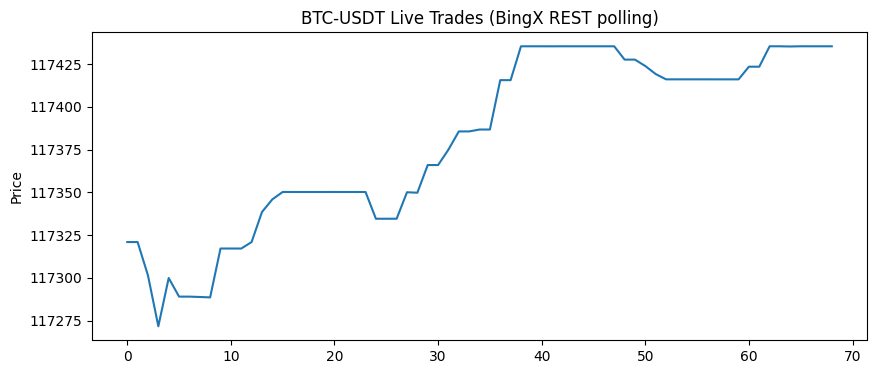

Last Price: 117435.43
Stopped by user


In [14]:
import requests, time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import deque

symbol = "BTC-USDT"
url = f"https://open-api.bingx.com/openApi/spot/v1/market/trades?symbol={symbol}"

prices = deque(maxlen=200)

plt.ioff()
fig, ax = plt.subplots(figsize=(10,4))

while True:
    try:
        r = requests.get(url).json()
        data = r.get("data", [])

        if data and "price" in data[0]:
            price = float(data[0]["price"])
            prices.append(price)

            clear_output(wait=True)
            ax.clear()
            ax.plot(list(prices))
            ax.set_title(f"{symbol} Live Trades (BingX REST polling)")
            ax.set_ylabel("Price")
            display(fig)

            print("Last Price:", price)
        else:
            print("ساختار غیرمنتظره:", r)

        time.sleep(2)

    except KeyboardInterrupt:
        print("Stopped by user")
        break


In [15]:
!pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.3 MB/s eta 0:00:00


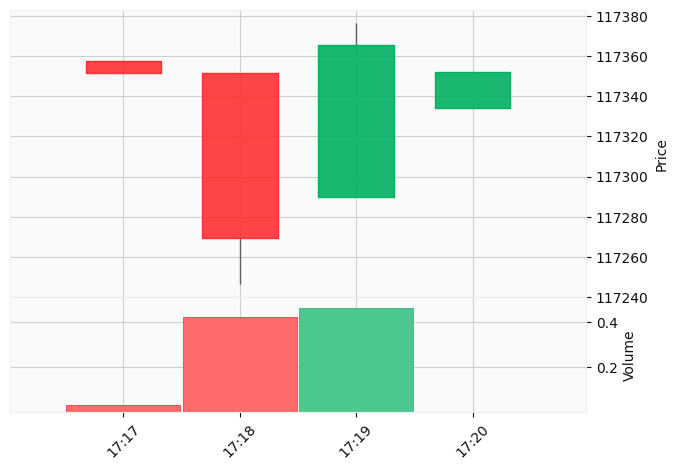

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-01 17:18:00,117351.54,117351.55,117246.41,117269.48,0.421455
2025-10-01 17:19:00,117289.64,117376.71,117289.64,117365.70,0.464997
2025-10-01 17:20:00,117334.27,117351.89,117334.27,117351.89,0.001038


Stopped by user


In [16]:
import requests, time
import pandas as pd
import mplfinance as mpf
from IPython.display import clear_output, display

symbol = "BTC-USDT"
url = f"https://open-api.bingx.com/openApi/spot/v1/market/trades?symbol={symbol}"

# دیتافریم خالی برای ذخیره کندل‌ها
df = pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume"])

while True:
    try:
        # گرفتن داده از API
        r = requests.get(url).json()
        trades = r.get("data", [])
        if not trades:
            print("هیچ داده‌ای برنگشت:", r)
            time.sleep(2)
            continue

        # آخرین معامله
        trade = trades[0]
        ts = pd.to_datetime(trade["time"], unit="ms")
        price = float(trade["price"])
        qty = float(trade["qty"])

        # گروه‌بندی بر اساس دقیقه
        minute = ts.floor("1min")

        if minute not in df["Date"].values:
            # شروع یک کندل جدید
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "Date": minute,
                    "Open": price,
                    "High": price,
                    "Low": price,
                    "Close": price,
                    "Volume": qty
                }])
            ], ignore_index=True)
        else:
            # آپدیت کندل فعلی
            idx = df.index[df["Date"] == minute][0]
            df.at[idx,"High"] = max(df.at[idx,"High"], price)
            df.at[idx,"Low"] = min(df.at[idx,"Low"], price)
            df.at[idx,"Close"] = price
            df.at[idx,"Volume"] += qty

        # نمایش فقط ۳۰ کندل آخر
        plot_df = df.set_index("Date").tail(30)

        clear_output(wait=True)
        mpf.plot(plot_df, type="candle", mav=(5,10), volume=True, style="yahoo")
        display(plot_df.tail(3))  # آخرین کندل‌ها برای چک کردن

        time.sleep(2)

    except KeyboardInterrupt:
        print("Stopped by user")
        break


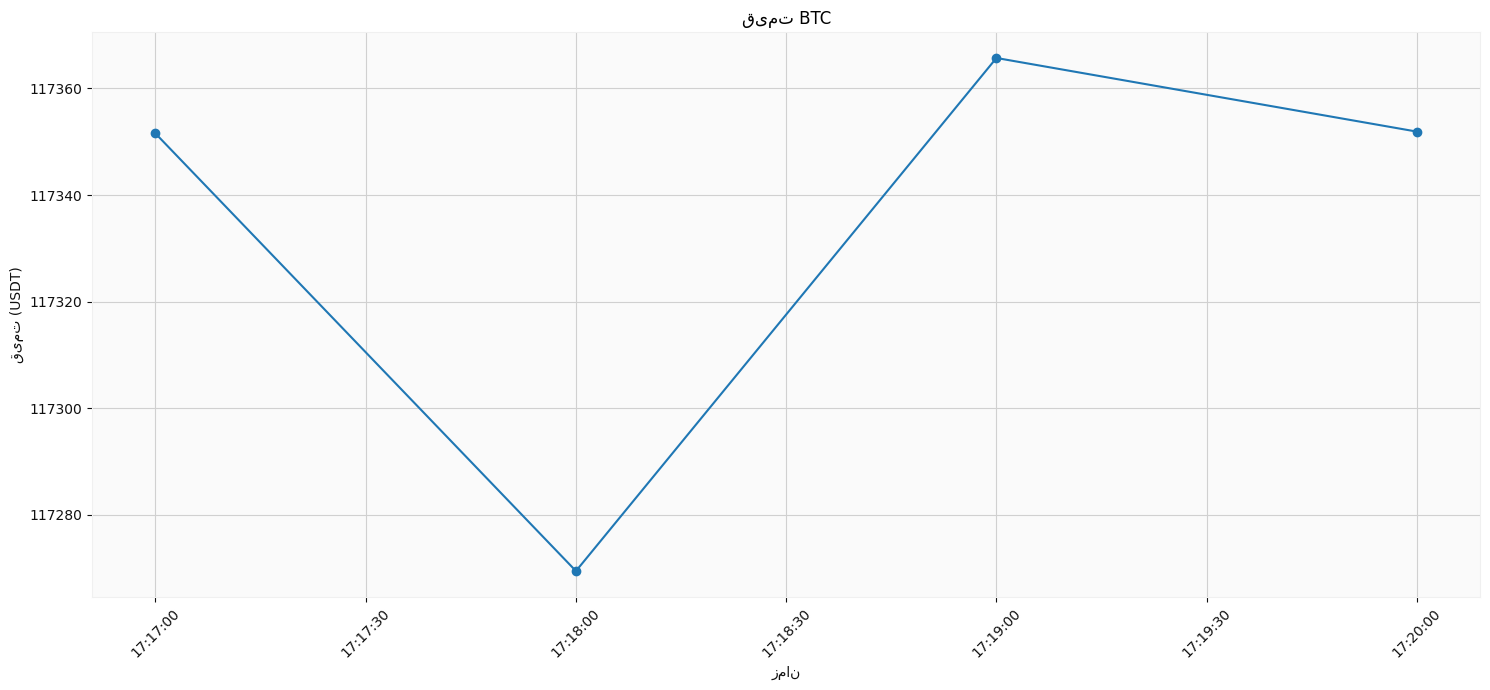

In [17]:
import matplotlib.pyplot as plt

# فرض کن df شامل ['Date','Open','High','Low','Close','Volume'] باشه
plot_df = df.tail(50)  # ۵۰ کندل آخر

plt.figure(figsize=(15,7))  # سایز بزرگتر
plt.plot(plot_df['Date'], plot_df['Close'], marker='o', linestyle='-')
plt.xticks(rotation=45)  # چرخش تاریخ‌ها
plt.title("قیمت BTC")
plt.xlabel("زمان")
plt.ylabel("قیمت (USDT)")
plt.grid(True)
plt.tight_layout()
plt.show()
